<div style="text-align: center;">
<h1>Reel Realities: How Gender and Age Shape Success Across Box Office and Streaming Platforms</h1>
</div>

### <u>Imports</u>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import plotly.graph_objects as go
import warnings

from src.data.dataloader import (
    CMUDatasetLoader, IMDBDatasetLoader, KaggleDatasetLoader, NumbersDatasetLoader)
from src.utils.EDA_utils import EDA
from src.scripts.streaming import get_streaming_dataframe
import src.models.regression as regression
import src.utils.data_utils as data_utils
import src.utils.evaluation_utils as evaluation_utils


# Suppress specific FutureWarnings about is_sparse being deprecated
warnings.filterwarnings(action="ignore", category=FutureWarning, module="sklearn", message=".*is_sparse is deprecated.*")

### 1. <u>Data cleaning and pre-processing</u>

#### 1.1 CMU Dataset

We will use three files of the CMU dataset:
1. "plot_summaries.txt" gives us the plots of the movies.
2. "movie.metadata.tsv" gives us information about the languages, countries, and genres of the movies.
3. "character.metadata.tsv" gives us information about actors and the characters they play.

In [2]:
directory = "data"
CMU_loader = CMUDatasetLoader(directory)
plot_summaries_df = CMU_loader.load_plot_summaries()

print(f"The plot summaries dataframe has {len(plot_summaries_df):,} values.")

The plot summaries dataframe has 42,303 values.


In [3]:
null_id = plot_summaries_df["Wikipedia_movie_ID"].isnull().sum()
empty_id = plot_summaries_df[plot_summaries_df["Wikipedia_movie_ID"] == ""]["Wikipedia_movie_ID"].sum()
null_plot = plot_summaries_df["Plot Summaries"].isnull().sum()
empty_plot = plot_summaries_df[plot_summaries_df["Plot Summaries"] == ""]["Plot Summaries"].sum()

print(f"Number of null values in 'Wikipedia_movie_ID': {null_id}")
print(f"Number of empty values in 'Wikipedia_movie_ID': {empty_id}")
print(f"Number of null values in 'Plot Summaries': {null_plot}")
print(f"Number of empty values in 'Plot Summaries': {empty_plot}")

Number of null values in 'Wikipedia_movie_ID': 0
Number of empty values in 'Wikipedia_movie_ID': 0
Number of null values in 'Plot Summaries': 0
Number of empty values in 'Plot Summaries': 0


In [4]:
movie_metadata_df = CMU_loader.load_movie_metadata()
print(f"The movie metadata dataframe has {len(movie_metadata_df):,} values.")

The movie metadata dataframe has 81,741 values.


In [5]:
movie_metadata_df["Movie_name"] = (movie_metadata_df["Movie_name"]
                    .str.strip()  #Remove leading/trailing whitespace
                    .str.lower()  #Convert to lowercase
                    .replace("", np.nan)  #Replace empty strings with NaN
                   )

In [6]:
# Movie languages, countries, and genres are formatted as a dictionary, but they are actually a string.
# We convert them to comma seperated strings. 

column_names_to_clean = ["Movie_countries", "Movie_languages", "Movie_genres"]
movie_metadata_df = data_utils.convert_dicts_to_strings(movie_metadata_df, column_names_to_clean)

# Cleaning the strings
movie_metadata_df = data_utils.clean_string_columns(movie_metadata_df, column_names_to_clean)

In [7]:
# There are inconsistencies in the date format: some rows have the date as year only, others as year-month, and some as year-month-day. 
# We convert them all to the year format only since the month and day are not relevant to our analysis.
movie_metadata_df, date_pattern_summary = data_utils.standardize_dates(movie_metadata_df, "Movie_release_date")
print("Pattern Summary:\n", date_pattern_summary)

Pattern Summary:
                        Pattern  Count
0       Full Date (YYYY-MM-DD)  39373
1             Year Only (YYYY)  32172
2                      Missing   6902
3  Year & Month Date (YYYY-MM)   3294


In [8]:
# Looking at the percentage of null values in the dataset
n_null_movie_metadata = ((movie_metadata_df.isnull().sum() / len(movie_metadata_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"movie_metadata_df:\n{n_null_movie_metadata}"
)

Percentage of null values per column:
movie_metadata_df:
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           8.44%
Movie_box_office_revenue    89.72%
Movie_runtime               25.02%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres                 0.00%
dtype: object


In [9]:
character_metadata_df = CMU_loader.load_character_metadata()

In [10]:
character_metadata_df["Actor_name"]= character_metadata_df["Actor_name"].fillna("unknown").str.lower()

# Ensures that the date columns are correctly interpreted as datetime objects in pandas. 
character_metadata_df["Movie_release_date"] = pd.to_datetime(character_metadata_df["Movie_release_date"], errors="coerce").dt.date
character_metadata_df["Actor_date_of_birth"] = pd.to_datetime(character_metadata_df["Actor_date_of_birth"], errors="coerce").dt.date

# Drop rows where "Movie_release_date" or "Actor_date_of_birth" is NaT
character_metadata_df.dropna(subset=["Movie_release_date", "Actor_date_of_birth"], inplace=True)

# Calculate Actor_age_at_movie_release if missing and data is available
character_metadata_df["Actor_age_at_movie_release"] = character_metadata_df.apply(
    lambda row: (row["Movie_release_date"] - row["Actor_date_of_birth"]).days // 365 if pd.isnull(row["Actor_age_at_movie_release"]) else row["Actor_age_at_movie_release"],
    axis=1
)

In [11]:
print(f"Movies without actor gender data: {character_metadata_df['Actor_gender'].isnull().sum()}") 

Movies without actor gender data: 892


We therefore drop the movies with no information on the gender of the actors.

In [12]:
character_metadata_df.dropna(subset=["Actor_gender"], inplace=True)

Now, let's group the actors together by creating a *Cast* column on the *movie_metadata_df*. 

In [13]:
cast_per_movie = character_metadata_df.groupby("Freebase_movie_ID")["Actor_name"].apply(lambda x: ", ".join(x)).reset_index()
cast_per_movie = cast_per_movie.rename(columns={"Actor_name": "Cast"})

movie_metadata_df = movie_metadata_df.merge(cast_per_movie, on="Freebase_movie_ID", how="left")

In [14]:
missing_cast_count = movie_metadata_df["Cast"].isna().sum()
total_movies = len(movie_metadata_df)
print(f"Movies without actor data: {missing_cast_count} out of {total_movies} ({missing_cast_count / total_movies * 100:.2f}%)")

Movies without actor data: 48556 out of 81741 (59.40%)


We decide to drop the movies without actor data since it is one of the most important features of our study. 

In [15]:
movie_metadata_df = movie_metadata_df.dropna(subset = ["Cast"])

In [16]:
# Create columns for male, female actor counts
actor_counts = character_metadata_df.groupby("Freebase_movie_ID")["Actor_gender"].value_counts().unstack(fill_value=0)
actor_counts = actor_counts.rename(columns={"M": "Male_actors", "F": "Female_actors"})

# Ensure all columns are present (set missing columns to 0 if necessary)
for col in ["Male_actors", "Female_actors"]:
    if col not in actor_counts.columns:
        actor_counts[col] = 0

actor_counts = actor_counts.reset_index()

# Merge actor counts with the movie_metadata_df DataFrame
movie_metadata_df = movie_metadata_df.merge(actor_counts, on="Freebase_movie_ID", how="left")

# Fill NaN values with 0 
movie_metadata_df[["Male_actors", "Female_actors"]] = movie_metadata_df[["Male_actors", "Female_actors"]].fillna(0)

In [17]:
# Calculate the percentage of female actors in each movie and round to two decimal places
movie_metadata_df["Female_actor_percentage"] = (
    (movie_metadata_df["Female_actors"] / 
     (movie_metadata_df["Female_actors"] + movie_metadata_df["Male_actors"])) * 100
).round(2)

#### 1.2 IMDB Dataset

We will use two IMDB datasets to decribe movies:
1. "title.ratings.tsv" gives us the ratings of the movies as voted by viewers. 
2. "title.basics.tsv", indexes into "title.ratings.tsv" using a alphanumeric unique identifier of the title. It gives general information about the movie such as runtime, release date and adult rating.
3. "title.crew.tsv", indexes into the previous two using the same alphanumeric unique identifier of the title. It gives information on the directors and writers of the movie.

Reference:
Internet Movie Database. (2024). IMDb non-commercial datasets. Retrieved from https://developer.imdb.com/non-commercial-datasets/

In [18]:
# Loading the IMDB datasets.
IMDB_loader = IMDBDatasetLoader(directory)
IMDB_ratings_df = IMDB_loader.load_ratings()

IMDB_basics_df = IMDB_loader.load_basics()

IMDB_crew_df = IMDB_loader.load_crew()

In [19]:
# Checking the lengths of the datasets
print(f"Length of IMDB_ratings_df: {len(IMDB_ratings_df):,}\n"
      f"Length of IMDB_basics_df: {len(IMDB_basics_df):,}\n"
      f"Length of IMDB_crew_df: {len(IMDB_crew_df):,}")

Length of IMDB_ratings_df: 1,498,616
Length of IMDB_basics_df: 697,175
Length of IMDB_crew_df: 10,571,537


Before dealing with the null values we will merge the dataframes together using the alphanumeric unique identifier.

In [20]:
# Merging all three datasets.
IMDB_merged_df = pd.merge(IMDB_ratings_df, IMDB_basics_df, how="inner", left_on="tconst", right_on="tconst")
IMDB_merged_df = pd.merge(IMDB_merged_df, IMDB_crew_df, how="inner", on="tconst")

In [21]:
print(f"The resulting merged dataframe has length: {len(IMDB_merged_df):,}.")

The resulting merged dataframe has length: 319,293.


Formatting the strings appropriately.

In [22]:
IMDB_merged_df = data_utils.clean_string_columns(IMDB_merged_df, ["Original_title", "Primary_title"])

We can now look at null values in the merged IMDB dataframe.

In [23]:
# Checking the percentage of null values in the dataset.
n_null_IMDB = ((IMDB_merged_df.isnull().sum() / len(IMDB_merged_df)) * 100).apply(lambda x: f"{x:,.2f}%")

print(
    f"Percentage of null values per column:\n"
    f"IMDB_ratings_df:\n{n_null_IMDB}"
)

Percentage of null values per column:
IMDB_ratings_df:
tconst               0.00%
Average_ratings      0.00%
Num_votes            0.00%
Title_type           0.00%
Primary_title        0.00%
Original_title       0.00%
Is_adult             0.00%
Start_year           0.01%
End_year           100.00%
Movie_runtime        9.98%
Movie_genres         3.26%
Directors            0.98%
Writers             12.30%
dtype: object


The end year is always missing. Other than that the proportion of missing values is very small (< 12%). End year is always null for movies and only makes sense for TV shows. It can thus be dropped. We can also drop the titleType column since we know they are all movies after the filtering that was done above.

In [24]:
# Dropping unnecessary columns.
IMDB_merged_df = IMDB_merged_df.drop(columns=["End_year", "Title_type"], axis=1)

print(f"The resulting dataframe has {len(IMDB_merged_df):,} rows.")

The resulting dataframe has 319,293 rows.


We will use ratings from the IMDB dataset during our study. However, these ratings are based on viewer votes. Initially we thought of discarding rows with too few votes. However, there could be a link between number of votes and number of views of a movie (although definitely not a direct one). We thus decided to keep all rows for the analysis.

#### 1.3 Merging the datasets

##### 1.3.1 Merging IMDB and CMU Movies

In [25]:
# Merging on the original title.
merge1 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on=["Original_title", "Start_year"],  right_on=["Movie_name", "Movie_release_date"])
# Merging on the primary title.
merge2 = pd.merge(IMDB_merged_df, movie_metadata_df, how="inner", left_on=["Primary_title", "Start_year"], right_on=["Movie_name", "Movie_release_date"])

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
movie_df = pd.concat([merge1, merge2]).drop_duplicates(subset=["tconst"]).reset_index(drop=True)

print(f"The resulting dataframe has {len(movie_df):,} rows.")

The resulting dataframe has 22,044 rows.


Some columns appear twice. Let's take a look at the proportion of null values in each duplicate column.

In [26]:
n_null_movie = (movie_df.isnull().sum()/len(movie_df)).apply(lambda x:f"{x:.2%}")

print(f"Percentage of null values per column:\n{n_null_movie}")

Percentage of null values per column:
tconst                       0.00%
Average_ratings              0.00%
Num_votes                    0.00%
Primary_title                0.00%
Original_title               0.00%
Is_adult                     0.00%
Start_year                   0.00%
Movie_runtime_x              3.11%
Movie_genres_x               0.61%
Directors                    0.16%
Writers                      2.41%
Wikipedia_movie_ID           0.00%
Freebase_movie_ID            0.00%
Movie_name                   0.00%
Movie_release_date           0.00%
Movie_box_office_revenue    72.33%
Movie_runtime_y             10.31%
Movie_languages              0.00%
Movie_countries              0.00%
Movie_genres_y               0.00%
Cast                         0.00%
Female_actors                0.00%
Male_actors                  0.00%
Female_actor_percentage      0.00%
dtype: object


We can see:
- Movie_runtime_x and Movie_runtime_y have 6.02% and 11.58% missing values respectively. We will combine the non null values from both these columns into a new column called runtimeMinutes and then drop the previous two columns. 
- Movie_genres_x has 1.54% missing values against 0.00% missing values for Movie_genres_y. Furthermore Movie_genres_y is from the CMU dataset and seems more complete. We will thus drop the genres_x column.

In [27]:
# Combining all non-null values from Movie_runtime_x and Movie_runtime_y into runtimeMinutes.
movie_df["Movie_runtime"] = movie_df["Movie_runtime_x"].combine_first(movie_df["Movie_runtime_y"])

# Dropping the unnecessary columns.
movie_df.drop(columns=["Movie_runtime_x", "Movie_runtime_y", "Movie_genres_x"], inplace=True)

Let's now see if Movie_name, originalTitle and primaryTitle are all necessary or if there are any redundancies.

In [28]:
test1 = movie_df["Movie_name"] == movie_df["Primary_title"]  
test2 = movie_df["Movie_name"] == movie_df["Original_title"]

# Checking if there are any movies for which Movie_name is not either in Primary_title or Original_title
print(f"There are {(~(test1 | test2)).sum().item()} movies for which Movie_name is in neither Primary_title ot Original_title.")

There are 0 movies for which Movie_name is in neither Primary_title ot Original_title.


We can see the Movie_name column is redundant as its information is either in primaryTitle or in originalTitle. We can thus drop this column.

In [29]:
movie_df.drop(columns="Movie_name", inplace=True)

We can now also drop movie identifier columns Freebase_movie_ID (as everything is already indexed). We will need tconst later on so we keep it.

In [30]:
movie_df.drop(columns=["Freebase_movie_ID"], inplace=True)

To connect this with the plot_summaries_df, we perform a left merge.

In [31]:
movie_df = pd.merge(movie_df, plot_summaries_df, on="Wikipedia_movie_ID", how="left")

Finally, we can drop Wikipedia_movie_ID, which is also a movie identifier column.

In [32]:
movie_df.drop(columns="Wikipedia_movie_ID", inplace=True)

In [33]:
movie_df["Movie_release_date"] = movie_df["Movie_release_date"].astype(float)

In [34]:
# Check for duplicates in movie_df
movie_df.duplicated(subset=['Primary_title', 'Original_title', 'Movie_release_date']).sum()

109

In [35]:
# Get the index of the max Num_votes for duplicated rows
idx = movie_df.groupby(['Primary_title', 'Original_title', 'Movie_release_date'])['Num_votes'].idxmax()

movie_df = movie_df.loc[idx]

movie_df.reset_index(drop=True, inplace=True)

# Check again if duplicated rows are still here
movie_df.duplicated(subset=['Primary_title', 'Original_title', 'Movie_release_date']).sum()

0

##### 1.3.3 Merging Kaggle and The numbers datasets to the rest

We have a problem, a lot of missing values(NaN or 0) in Movie box office revenue in movie_df and no production budget included. 
These two new datasets include information about movies revenue and budget and other attributes which are crucial for our analysis.

- `Kaggle_df`: Contains important details about movies, including budgets, genres, and revenue.
- `TheNumbers_df`: Provides detailed financial data, focusing on budget and box office gross both domestically and worldwide.

In [36]:
Kaggle_df = KaggleDatasetLoader(directory).load_kaggle()
TheNumbers_df = NumbersDatasetLoader(directory).load_numbers()

Quickly view the structure of the dataframes to understand the data types and confirm data has loaded correctly

In [37]:
Kaggle_df.head()

,budget,genres,original_title,popularity,production_companies,production_countries,revenue
0,237000000.0,Action Adventure Fantasy Science Fiction,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.787965e+09
1,300000000.0,Adventure Fantasy Action,Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",9.610000e+08
2,245000000.0,Action Adventure Crime,Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",8.806746e+08
3,250000000.0,Action Crime Drama Thriller,The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1.084939e+09
4,260000000.0,Action Adventure Science Fiction,John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2.841391e+08


In [38]:
# Clean and convert financials to float for consistency with the movie_df
TheNumbers_df = data_utils.clean_currency_columns(TheNumbers_df, ["production_budget", "domestic_gross", "worldwide_gross"])

In [39]:
TheNumbers_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09


We now perform an outer merge to include all records from both datasets, aligning them based on movie titles.


In [40]:
# Normalize the title columns for case insensitive matching
Kaggle_df = data_utils.clean_string_columns(Kaggle_df, ["original_title"])
TheNumbers_df = data_utils.clean_string_columns(TheNumbers_df, ["movie"])

# Merge both dataframes on the title columns
merged_df = pd.merge(Kaggle_df, TheNumbers_df, left_on="original_title", right_on="movie", how="outer")

##### Post-merge cleaning

We create the main financial columns ("movie_budget" and "movie_revenue") by selecting non-null and non-zero values, prioritizing data from TheNumbers dataset when available.


In [41]:
merged_df["movie_budget"] = np.where((merged_df["production_budget"].notna() & (merged_df["production_budget"] != 0)),
                                     merged_df["production_budget"],
                                     merged_df["budget"])

merged_df["movie_revenue"] = np.where((merged_df["worldwide_gross"].notna() & (merged_df["worldwide_gross"] != 0)),
                                      merged_df["worldwide_gross"],
                                      merged_df["revenue"])

# Drop the original columns that were merged into new ones
merged_df.drop(columns=["budget", "revenue", "production_budget", "worldwide_gross", "movie"], inplace=True)

Filter out movies where both budget and revenue data are missing or zero, as they do not provide value for financial analysis.


In [42]:
# Create a mask where both columns are either zero or NaN
mask = (
    (merged_df["movie_budget"].isna() | (merged_df["movie_budget"] == 0)) &
    (merged_df["movie_revenue"].isna() | (merged_df["movie_revenue"] == 0))
)

# Apply the mask and drop those rows
df_filtered = merged_df[~mask]

In [43]:
print("The number of available and relevant movie budget and revenue information is " + str(df_filtered["movie_budget"].size))

df_filtered.head()

The number of available and relevant movie budget and revenue information is 6085


,genres,original_title,popularity,production_companies,production_countries,id,release_date,domestic_gross,movie_budget,movie_revenue
0,Drama Mystery Horror Thriller,#horror,2.815228,"[{""name"": ""AST Studios"", ""id"": 75277}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",16.0,"Nov 20, 2015",0.0,1500000.0,0.0
1,Comedy Drama Romance,(500) days of summer,45.610993,"[{""name"": ""Fox Searchlight Pictures"", ""id"": 43...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",55.0,"Jul 17, 2009",32425665.0,7500000.0,34439060.0
2,Thriller Science Fiction Drama,10 cloverfield lane,53.698683,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",54.0,"Mar 11, 2016",72082999.0,5000000.0,108286422.0
3,Drama,10 days in a madhouse,0.489271,[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",48.0,"Nov 11, 2015",14616.0,12000000.0,14616.0
4,Comedy Romance Drama,10 things i hate about you,54.550275,"[{""name"": ""Mad Chance"", ""id"": 1757}, {""name"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",63.0,"Mar 31, 1999",38177966.0,13000000.0,60413950.0


Two merging strategies are employed here to maximize the potential for matching records across the datasets:

Original Title Merge: Merging based on the Original_title from movie_df to the original_title from df_filtered to catch the most direct title matches. 

Primary Title Merge: Using Primary_title as an alternative matching criterion, knowing that some movies might be listed under alternate titles.


In [44]:
# Convert the 'Release_Date' column to datetime
df_filtered['release_date'] = pd.to_datetime(df_filtered['release_date'])

# Extract the year from the datetime
df_filtered['release_date'] = df_filtered['release_date'].dt.year

In [45]:
# Normalize the title columns for case-insensitive matching
movie_df["Original_title"] = movie_df["Original_title"].str.strip().str.lower()
movie_df["Primary_title"] = movie_df["Primary_title"].str.strip().str.lower()

# Merging on the original title.
merge1 = pd.merge(movie_df, df_filtered, how="inner", left_on=["Original_title", "Movie_release_date"], right_on=["original_title", "release_date"])
# Merging on the secondary title.
merge2 = pd.merge(movie_df, df_filtered, how="inner", left_on=["Primary_title", "Movie_release_date"], right_on=["original_title", "release_date"])

# Concatenating and dropping duplicates that appear from movies with the same Original_title and Primary_title.
final_df = pd.concat([merge1, merge2]).drop_duplicates(subset=["tconst"]).reset_index(drop=True)

# Filter out movies where revenue data is missing or zero and prioritize initial revenue
final_df["final_movie_revenue"] = np.where(
    (final_df["Movie_box_office_revenue"].notna() & (final_df["Movie_box_office_revenue"] != 0)),
    final_df["Movie_box_office_revenue"],
    final_df["movie_revenue"]
)

final_df.drop(columns=["Movie_box_office_revenue", "domestic_gross", "movie_revenue", "original_title", "genres", "id", "release_date"], inplace=True, errors="ignore")

# Renaming the columns to follow the convention
rename_columns = {"popularity":"Popularity", 
                  "production_companies":"Production_companies", 
                  "prodcution_countries":"Production_countries",
                  "movie_budget":"Movie_budget",
                  "final_movie_revenue":"Final_movie_revenue",
                  "Movie_genres_y":"Movie_genres"}

final_df.rename(columns=rename_columns, inplace=True)


print(f"The resulting dataframe has {len(final_df):,} rows.")
final_df.head()

The resulting dataframe has 2,371 rows.


,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,Female_actors,Male_actors,Female_actor_percentage,Movie_runtime,Plot Summaries,Popularity,Production_companies,production_countries,Movie_budget,Final_movie_revenue
0,tt0147800,7.3,402271,10 things i hate about you,10 things i hate about you,0,1999,nm0432627,"nm0527581,nm0809006,nm0000636",1999.0,...,6,7,46.15,97,"Cameron James , a new student at Padua Stadium...",54.550275,"[{""name"": ""Mad Chance"", ""id"": 1757}, {""name"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",13000000.0,53478166.0
1,tt0211181,4.8,40166,102 dalmatians,102 dalmatians,0,2000,nm0510674,"nm0807977,nm0118649,nm0716391,nm0879318,nm0925276",2000.0,...,2,5,28.57,100,"After three years in prison, Cruella de Vil ha...",9.895061,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",85000000.0,183611771.0
2,tt0360323,6.3,7052,10th & wolf,10th & wolf,0,2006,nm0604263,"nm0604263,nm0824481",2006.0,...,2,8,20.00,107,"Tommy is the son of a Mafia hitman, who, after...",3.942464,"[{""name"": ""Thinkfilm"", ""id"": 446}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",8000000.0,143782.0
3,tt0050083,9.0,892430,12 angry men,12 angry men,0,1957,nm0001486,nm0741627,1957.0,...,0,14,0.00,96,The story begins in a courtroom where an 18-ye...,59.259204,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",340000.0,1000000.0
4,tt1160368,5.6,30914,12 rounds,12 rounds,0,2009,nm0001317,nm2896816,2009.0,...,4,11,26.67,108,A sting operation to capture notorious arms de...,15.661350,"[{""name"": ""The Mark Gordon Company"", ""id"": 155...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",20000000.0,18184083.0


### 2. Our success metric

#### Financial Analysis

##### Calculating Return on Investment (ROI)

To provide insights into the financial success of the movies, we calculate the Return on Investment (ROI). This metric is derived by comparing the movie"s final revenue to its budget.

- **Condition**: Ensure that both `movie_budget` and `final_movie_revenue` are non-zero and non-null to avoid division errors and ensure data integrity


In [46]:
final_df = evaluation_utils.calculate_roi(final_df, "Movie_budget", "Final_movie_revenue")
print("There is now " + str(final_df["Final_movie_revenue"].size) + " movies to work with in the financial success analysis")

There is now 2364 movies to work with in the financial success analysis


#### Data Normalization and Scaling

Given the varied scales of ratings and ROI, we standardize these features to a common scale using both Standard and Min-Max scalers. 

In [47]:
# Initialize scalers
final_df = evaluation_utils.scale_features(final_df)

#### Weighted Success Metric

To evaluate overall movie success, we calculate a weighted sum of normalized ratings and ROI, assigning double the weight to ROI given its financial significance in assessing success.

In [48]:
# Calculate movie success which is a weighted sum choosing that the ROI feature will have double the importance of ratings
#final_df = evaluation_utils.calculate_weighted_success(final_df, 0.67)

final_df.head()

,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,Female_actor_percentage,Movie_runtime,Plot Summaries,Popularity,Production_companies,production_countries,Movie_budget,Final_movie_revenue,ROI,Normalized_Rating
0,tt0147800,7.3,402271,10 things i hate about you,10 things i hate about you,0,1999,nm0432627,"nm0527581,nm0809006,nm0000636",1999.0,...,46.15,97,"Cameron James , a new student at Padua Stadium...",54.550275,"[{""name"": ""Mad Chance"", ""id"": 1757}, {""name"": ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",13000000.0,53478166.0,3.113705,0.73
1,tt0211181,4.8,40166,102 dalmatians,102 dalmatians,0,2000,nm0510674,"nm0807977,nm0118649,nm0716391,nm0879318,nm0925276",2000.0,...,28.57,100,"After three years in prison, Cruella de Vil ha...",9.895061,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",85000000.0,183611771.0,1.160138,0.48
2,tt0360323,6.3,7052,10th & wolf,10th & wolf,0,2006,nm0604263,"nm0604263,nm0824481",2006.0,...,20.00,107,"Tommy is the son of a Mafia hitman, who, after...",3.942464,"[{""name"": ""Thinkfilm"", ""id"": 446}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",8000000.0,143782.0,-0.982027,0.63
3,tt0050083,9.0,892430,12 angry men,12 angry men,0,1957,nm0001486,nm0741627,1957.0,...,0.00,96,The story begins in a courtroom where an 18-ye...,59.259204,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",340000.0,1000000.0,1.941176,0.90
4,tt1160368,5.6,30914,12 rounds,12 rounds,0,2009,nm0001317,nm2896816,2009.0,...,26.67,108,A sting operation to capture notorious arms de...,15.661350,"[{""name"": ""The Mark Gordon Company"", ""id"": 155...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",20000000.0,18184083.0,-0.090796,0.56


### 3. Gender and age vs success

Now that we have have established our success metric, we can evaluate the effect of actors' gender on the success of a movie. 

The best way we chose in order to conduct our analysis is a **Regression analysis**. Indeed, this will allow us to quantify and understand the relationship between gender, age, and other factors on ROI, ratings and our success metric while controlling for potential confounders.

Before diving into regression, we should perform an **Exploratory Data Analysis (EDA)** to understand the relationships among variables and detect any anomalies.

#### 1.1 Exploratory Data Analysis (EDA)

First, let's list the variable of interest:

Categorical variable:
- *Actor_gender*: An actor is either Male or Female. 
- *isAdult*: A boolean. Returns 1 if it a +18 rated movie
- *Movie_genre*
- *Movie_countries*, 
- *Movie_languages*

Continous variable:
- *Average_female_actor_age*: Represents the average age of the female actresses. 
- *Average_male_actor_age*: Represents the average age of the male actresses.
- *Average_ratings* and *Movie_box_office_revenue*: These are the dependent variables of our studies.    



##### A quick comment about the dependent variables:
The goal of our study is to look at ratings, ROI and our succes metric. However, due to complications with finding enough data for the ROI and success metric estimation we will need to postpone the in-depth analysis to P3.

##### 1.1.1 Univariate Analysis of continuous variables

As a numerical analysis, we can show a table with the minimum, maximum, mean, standard deviation (SD) and median of each variable.

In [49]:
# Initialize object for EDA processing
eda = EDA(final_df.copy())

In [50]:
pd.options.display.float_format = "{:,.2f}".format

# Convert columns to numeric and drop rows with missing data.
eda.dataframe[eda.numeric_columns] = eda.dataframe[eda.numeric_columns].apply(pd.to_numeric, errors="coerce")
eda.dataframe.dropna(subset=eda.numeric_columns, inplace=True)

# Summary statistics
summary_table = eda.summary()

summary_table

,Min,Max,Mean,SD,Median
Average_ratings,1.90,9.30,6.49,1.02,6.60
Num_votes,15.00,"2,962,241.00","180,926.53","266,922.31","96,254.50"
Movie_release_date,"1,916.00","2,014.00","1,999.84",12.14,"2,003.00"
Movie_budget,"7,000.00","425,000,000.00","41,813,030.83","43,097,470.32","29,500,000.00"
Final_movie_revenue,423.00,"2,782,275,172.00","121,971,196.29","179,309,207.50","60,225,819.50"
ROI,-1.00,413.40,4.03,18.87,1.24
Movie_runtime,49.00,260.00,110.52,20.94,107.00
Female_actors,0.00,17.00,4.12,2.55,4.00
Male_actors,0.00,38.00,8.94,4.23,8.00


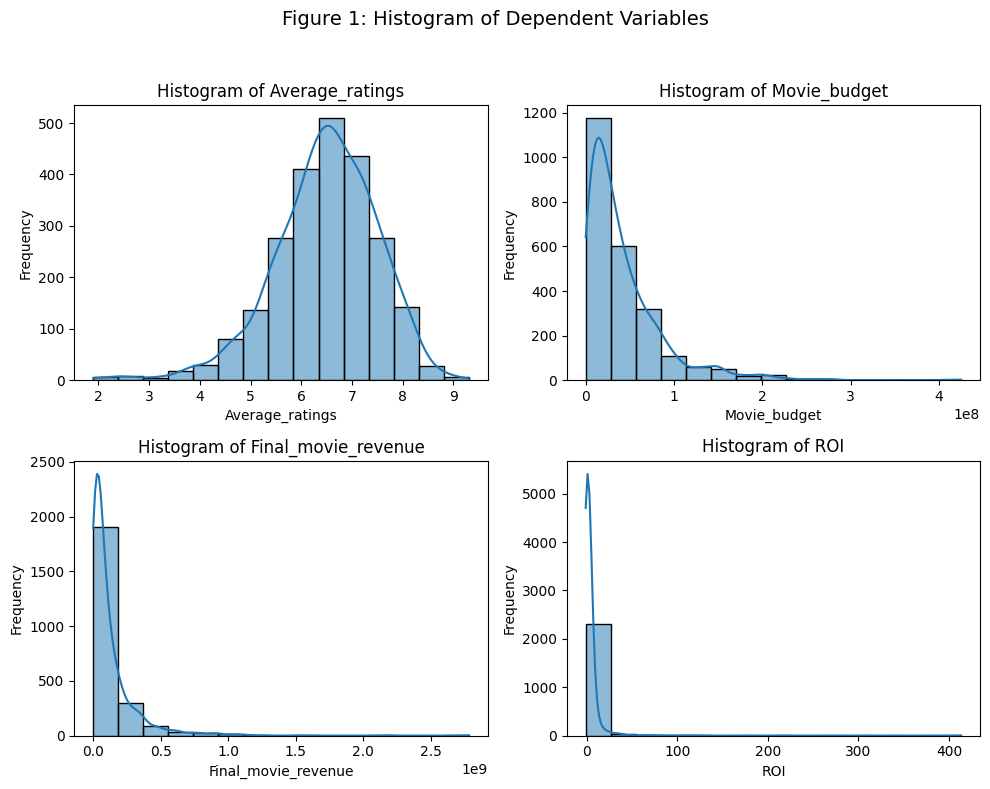

In [51]:
eda.plot_histograms(
    variables=["Average_ratings", "Movie_budget", "Final_movie_revenue", "ROI"],
    title="Figure 1: Histogram of Dependent Variables",
    bins=15,
    layout=(2, 2)
)

As we can see in Figure 1, the histogram for *Average_ratings* is bell-shaped, indicating a **normal distribution** of movie ratings.

As for the distribution of *Movie_budget*, *Final_movie_revenue* and *ROI* are highly skewed. In order to adresse that, we have to apply a log transformation to ROI which is a combination of the budget and revenue.

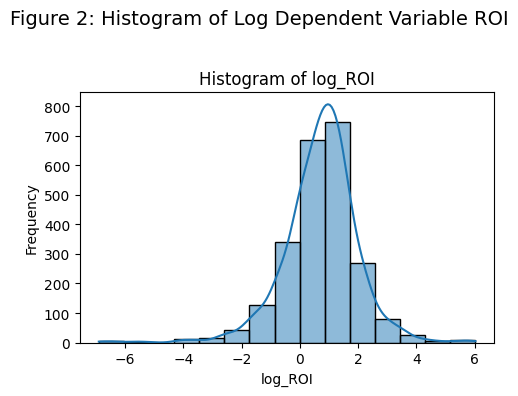

In [52]:
# Apply log transformation to skewed dependent variables
eda.dataframe = evaluation_utils.log_transform(eda.dataframe, ["ROI"])


eda.plot_histograms(
    variables=["log_ROI"],
    title="Figure 2: Histogram of Log Dependent Variable ROI",
    bins=15,
    layout=(1, 1)
)

Now we have successfully obtained a normal distribution for the *ROI*. 

Let's now look at our independent variables.

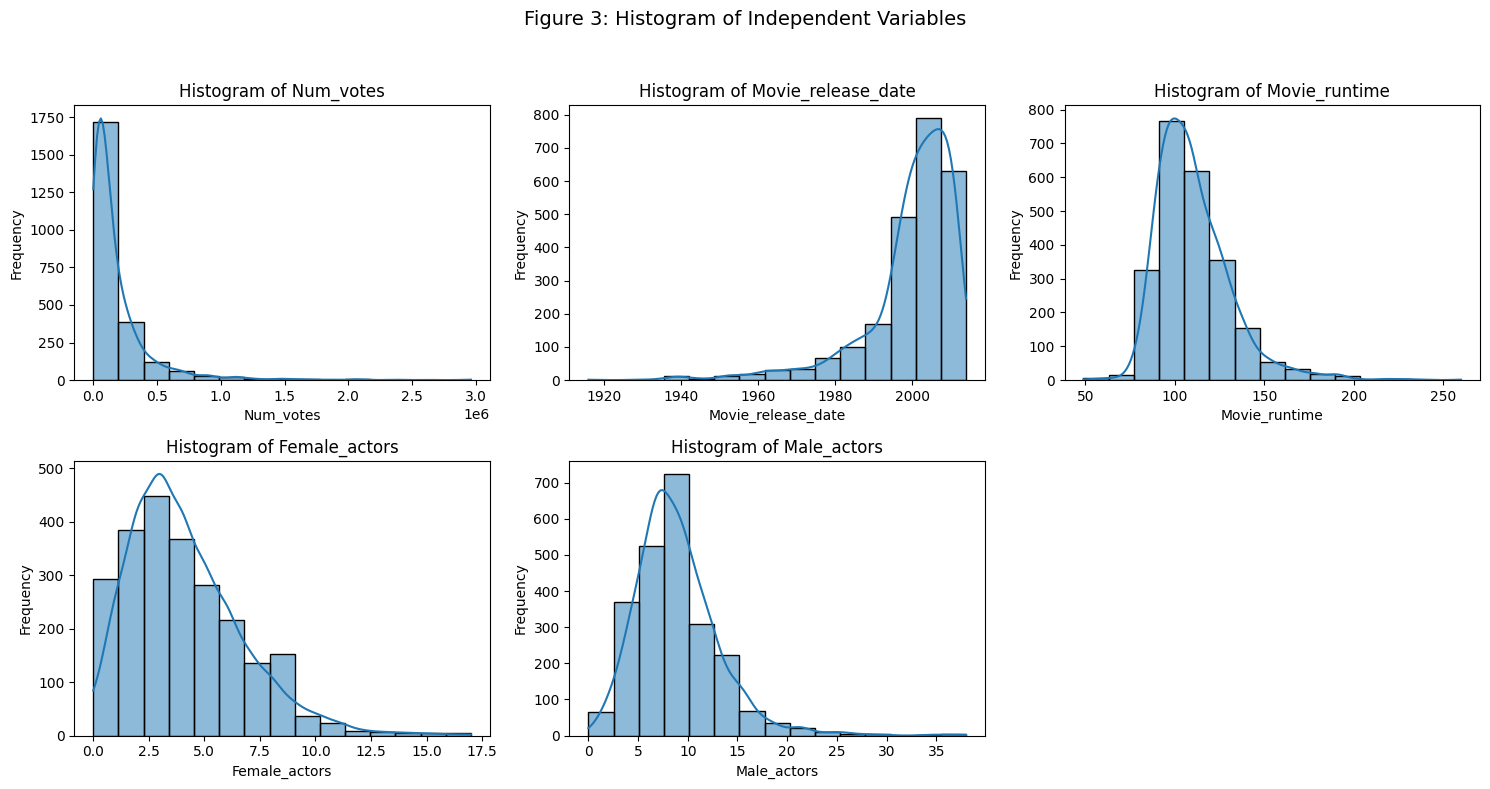

In [53]:
eda.plot_histograms(
    variables=["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"],
    title="Figure 3: Histogram of Independent Variables",
    bins=15,
    layout=(2, 3)
)

The histogram for the *Movie_release_date* shows an increase in movie releases after the 1980s, with a sharp spike around the 2000s. This suggests that the number of movie releases accelerated significantly in the late 20th and early 21st centuries.

Since the histogram for *Movie_release_date*, *Movie_runtime*, *Female_actors* and *Male_actors* are bell-shaped and follow a normal distribution, thus we keep these variables as they are.

For the *Num_votes*, we need to apply log transformation since it is skewed.

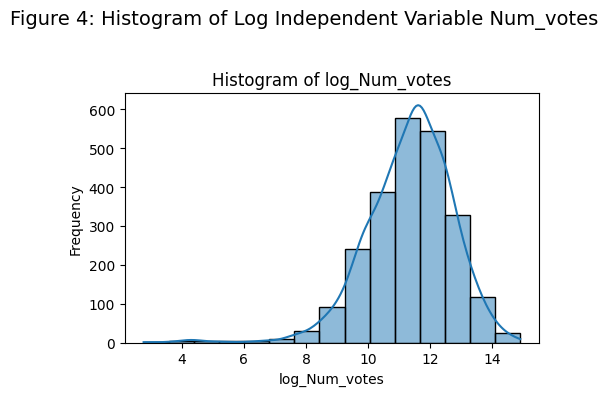

In [54]:
# Apply log transformation to skewed independent variables
eda.dataframe = evaluation_utils.log_transform(eda.dataframe, ["Num_votes"])

eda.plot_histograms(
    variables=["log_Num_votes"],
    title="Figure 4: Histogram of Log Independent Variable Num_votes",
    bins=15,
    layout=(1, 1)
)

Log of Num_votes: A normal distribution with most movies receiving moderate number of votes and a smaller group of popular movies getting significantly more votes 

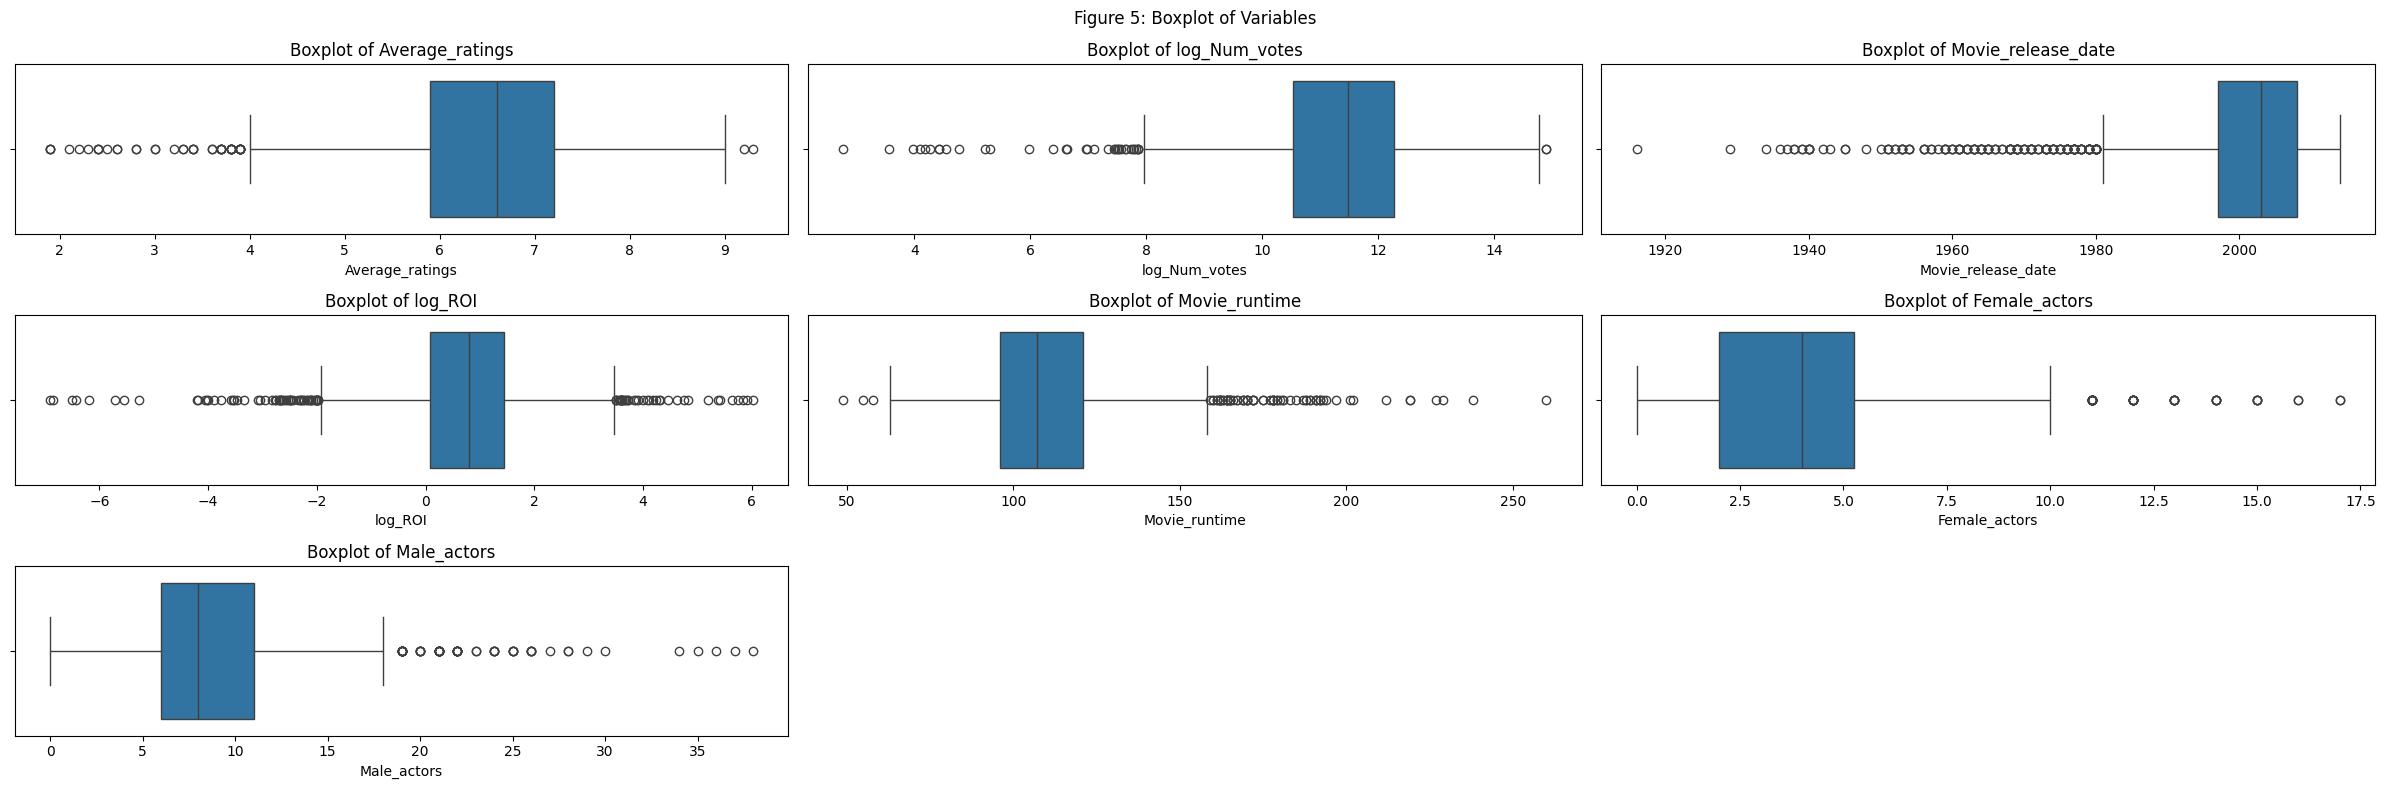

In [55]:
eda.numeric_columns = ["Average_ratings",
                   "log_Num_votes",
                   "Movie_release_date",
                   "log_ROI",
                   "Movie_runtime",
                   "Female_actors",
                   "Male_actors"]

eda.plot_boxplots()

We filter movies with a release date after 1970 and a runtime below 200 minutes to ensure meaningful results from our linear regression model. The movies post-1970 align more with modern filmmaking trends, audience preferences, and even available data quality, all contributing to minimizing potential biases based on older production trends. Limiting runtime to under 200 minutes helps exclude extreme outliers that could distort model coefficients, as excessively long films are rare and often follow unconventional storytelling formats, making them less representative of typical movie characteristics.

In [56]:
# Filtering movies after 1970 awith runtime less than 200 minutes
eda.dataframe = eda.dataframe[(eda.dataframe["Movie_release_date"] > 1970) & (eda.dataframe["Movie_runtime"] < 200)]

In [57]:
print(f"After filtering the dataframe we are left with {len(eda.dataframe):,} movies.")

After filtering the dataframe we are left with 2,268 movies.


We now have to focus on outliers and removing them for a more accurate modeling. From the boxplots, we chose the remove the outliers of the *Movie_box_office_revenue* and the *Minutes_runtime* variables. To do that, we use the **InterQuartile Range (IQR) method**, which identifies values that are significantly higher or lower than the majority of the data.

The *remove_outliers* function will calculate the IQR for each column specified and removes any rows with values outside the range:

$[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$


In [58]:
# eda.numeric_columns = ["Average_ratings",
#                    "log_Num_votes",
#                    "Movie_release_date",
#                    #"log_Final_movie_revenue",
#                    "log_ROI",
#                    "log_Movie_runtime",
#                    "log_Female_actors",
#                    "log_Male_actors",
#                    "Movie_success"]

# # Dataframe without outliers
# eda.dataframe = data_utils.remove_outliers(eda.dataframe, eda.numeric_columns)

# eda.plot_boxplots()

In [59]:
# print(f"After removing the outliers and dropping the null values, we are left with {len(eda.dataframe):,} movies.")

##### 1.1.2 Bivariate Analysis of continuous variables

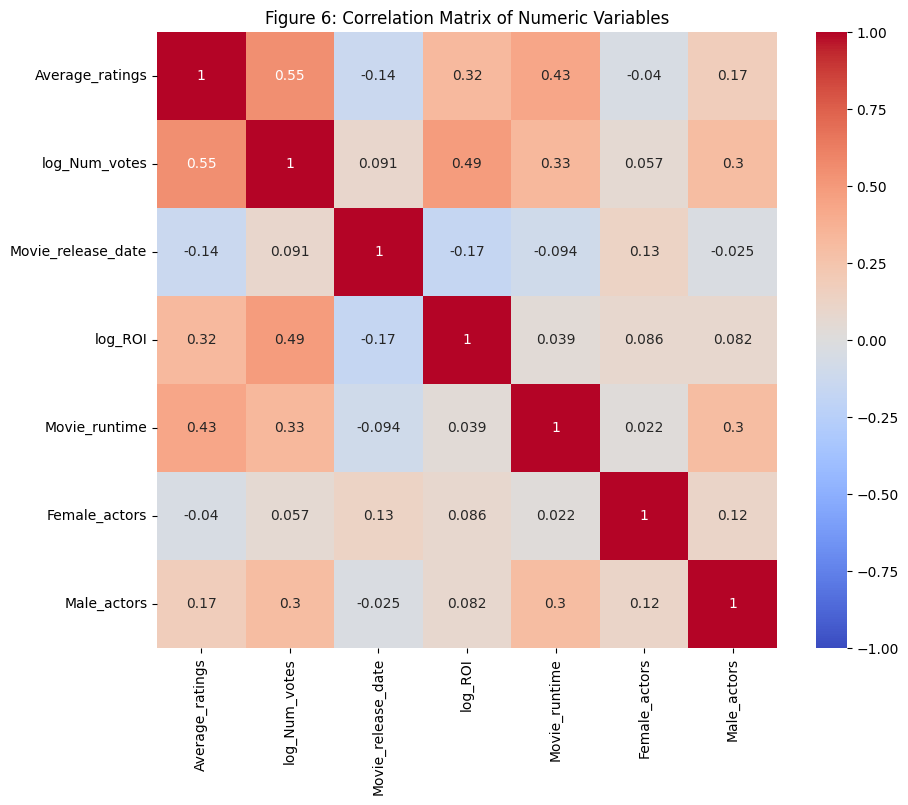

In [60]:
eda.plot_correlation_matrix()

The correlation matrix for the continuous variables in our dataset shows the following relationships:

•⁠  *⁠Female_actors* and *Male_actors*: The correlation coefficient is *0.12*, indicating a weak positive correlation. This suggests that movies with a higher number of female actors also tend to have a higher number of male actors. We note that this could indicate a general tendency for larger casts to include more actors of both genders.

•⁠  *log_Female_actors* and *Movie_release_date*: The correlation coefficient is *0.13*, indicating a weak positive correlation. This suggests that more recent movies tend to include a higher number of female actors. 

While gender composition affects the correlation, these findings highlight the need for deeper analysis (e.g., regression) to control for potential confounders and isolate the impact of gender on box office success.

In [61]:
eda.frequency_actors_gender()

#### 1.1.3 Analysis and encoding of categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

##### 1.1.3.1 Analysis of the Movies' genres

We set a cutoff threshold of 200. This means all genres with less than 200 occurences will be discarded. 

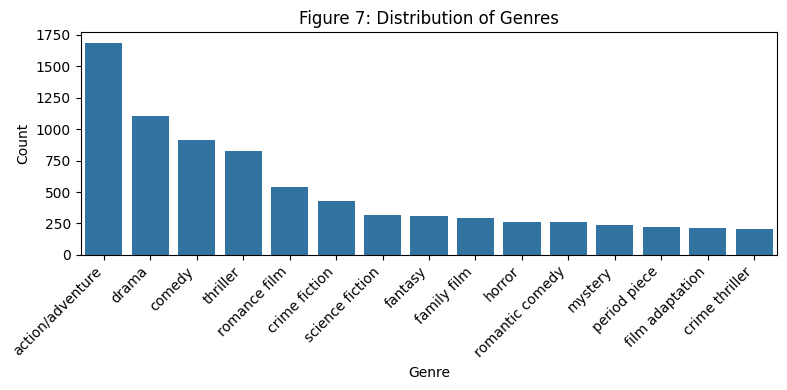

There are 15 genres with more that 200 occurences.


In [62]:
filtered_genre_counts = eda.filter_and_count(column_name="Movie_genres", threshold=200)

Let us check if this restricts our study to too few movies.

In [63]:
popular_genres = eda.analyze_popular_genres(filtered_genre_counts=filtered_genre_counts)

There are 2246 movies that belong to at least one of the 15 most popular genres. 
There were 2268 movies in the dataset before this operation, meaning we lost 0.97% of the movies.


We can drop the movies that have none of the most popular genres. We can also assume that the genres are ordered by relevance. This assumption was made after manually checking for 50 randomly sampled movies. It was true for all 50. We will thus keep for each movie, the first popular genre that appears.

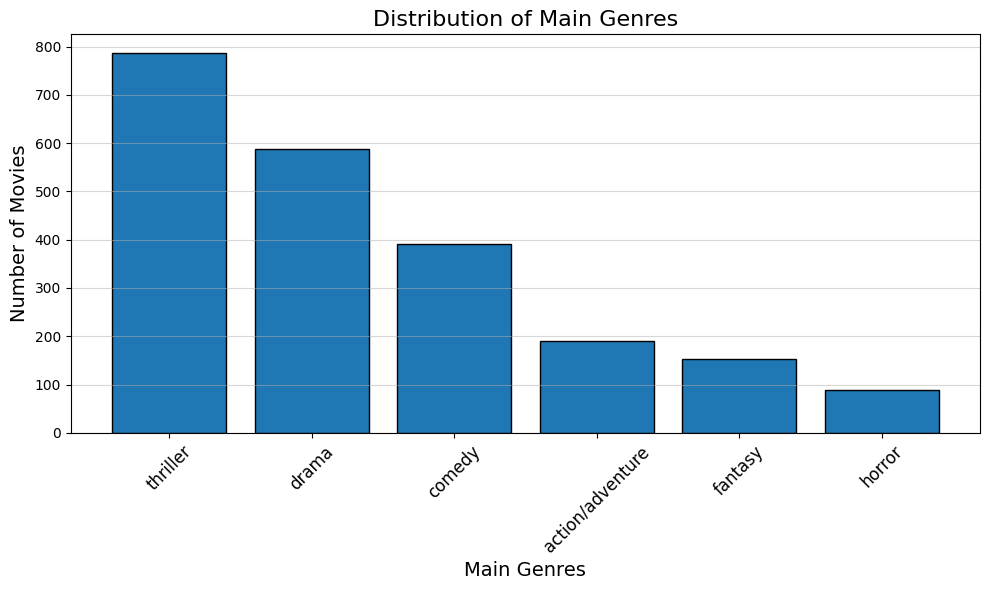

In [64]:
# Creating a new column named "Main_genre" that stores, for each movie, the first occurence of one of the popular genres
eda.get_main_genres(popular_genres=popular_genres)

We can now create the dummy variables for the "Main_genre" column using one-hot encoding.

In [65]:
eda.dataframe["Movie_main_genre"] = eda.dataframe["Main_genre"] # Backup the original genre column before get_dummies
eda.dataframe = pd.get_dummies(eda.dataframe, columns=["Main_genre"], drop_first=True)
eda.dataframe.sample(5)

,tconst,Average_ratings,Num_votes,Primary_title,Original_title,Is_adult,Start_year,Directors,Writers,Movie_release_date,...,ROI,Normalized_Rating,log_ROI,log_Num_votes,Movie_main_genre,Main_genre_comedy,Main_genre_drama,Main_genre_fantasy,Main_genre_horror,Main_genre_thriller
1878,tt0800080,6.60,533239,the incredible hulk,the incredible hulk,0,2008,nm0504642,"nm0672015,nm0498278,nm0456158","2,008.00",...,0.92,0.66,0.65,13.19,thriller,False,False,False,False,True
1089,tt0765476,5.10,44336,meet dave,meet dave,0,2008,nm0005367,"nm0338576,nm0179132","2,008.00",...,-0.16,0.51,-0.17,10.70,comedy,True,False,False,False,False
1461,tt0387575,4.90,51407,seed of chucky,seed of chucky,0,2004,nm0238841,nm0238841,"2,004.00",...,-0.14,0.49,-0.16,10.85,thriller,False,False,False,False,True
2070,tt2017020,5.30,47147,the smurfs 2,the smurfs 2,0,2013,nm0331532,"nm0826425,nm0918955,nm0771065,nm0740115,nm0456...","2,013.00",...,2.17,0.53,1.15,10.76,fantasy,False,False,True,False,False
241,tt0389790,6.10,184157,bee movie,bee movie,0,2007,"nm0971239,nm9054338","nm0000632,nm0272324,nm0546267,nm0732165,nm0552...","2,007.00",...,0.92,0.61,0.65,12.12,comedy,True,False,False,False,False


In [66]:
eda.plot_female_percentage(columns= ["Movie_release_date"], plot_type="Line")

In [67]:
eda.plot_female_percentage(columns=["Movie_main_genre"], plot_type = "Bar")


In [68]:
eda.plot_female_percentage(columns=["Movie_release_date", "Movie_main_genre"], plot_type = "Interactif by genre")

##### 1.1.3.2 Analysis of the Movies' languages

We will plot the top 5 languages by number of occurences:

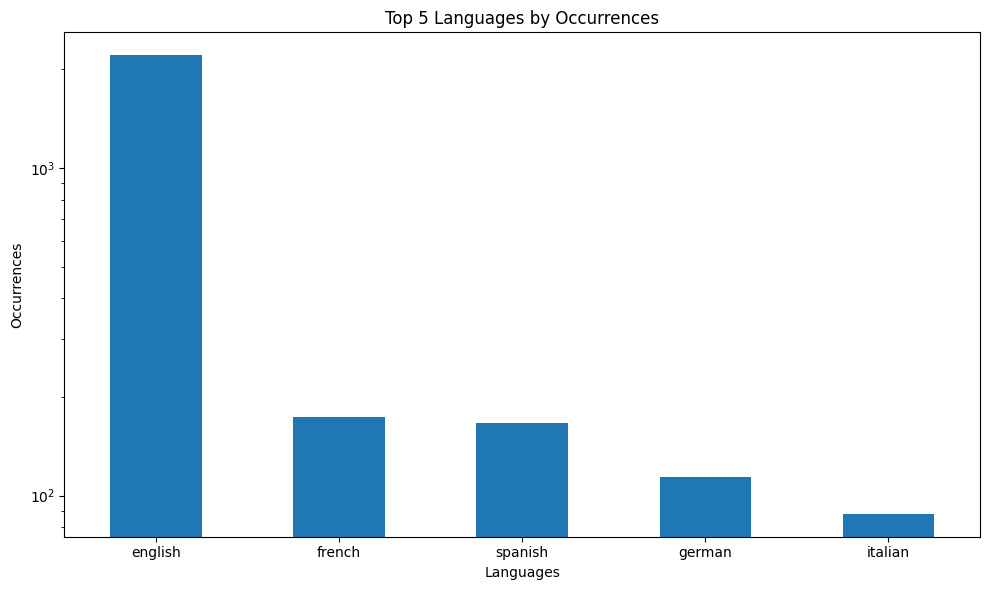

In [69]:
eda.analyze_languages()

We have an unbalanced dataset with English being much more prominent than other languages.

Categorizing movies into two groups: 
- those available exclusively in English, 
- those available in other languages (which may include English alongside another language).

This will be done through the creation of the boolean "Is_not_only_english" which is True when the movie is available in another language.

In [70]:
eda.categorize_languages()

There are 686 movies that are available in other languages and 1560 movies that are only available in English.


##### 1.1.3.2 Analysis of the Movies' countries

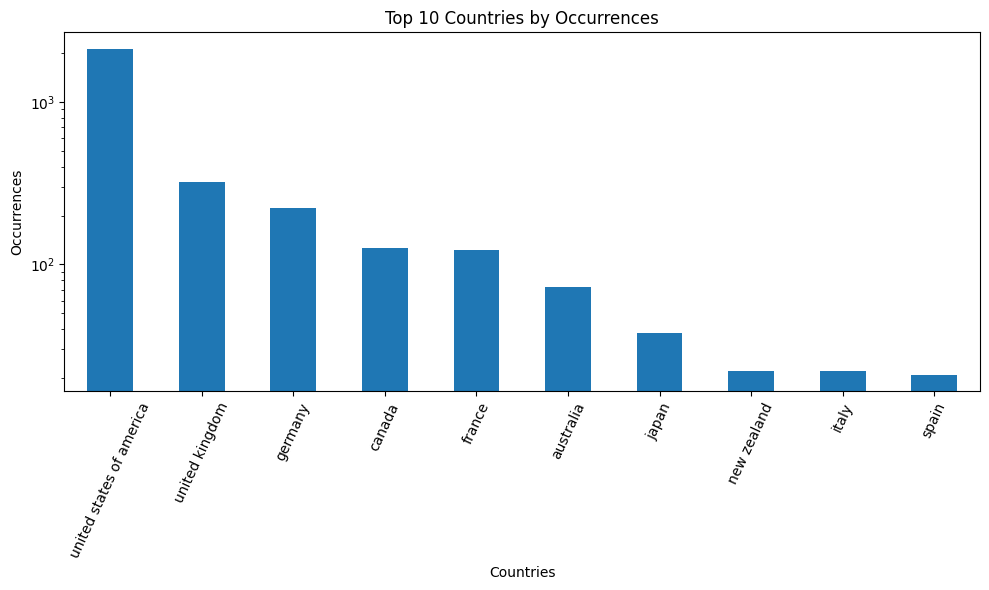

In [71]:
eda.analyze_countries()

We have a very similar situation to the languages. The United States of America have a much more prominent number of movies. We will thus proceed like previously by categorizing the movies into two groups:
- USA movies 
- Movies from other countries 

This will be done through the creation of the boolean "Is_USA_movie" which is True when the movie is from the USA.

In [72]:
count_usa_movies = (eda.dataframe["Movie_countries"] == "united states of america").sum()
count_other_countries_movie = len(eda.dataframe) - count_usa_movies 
print(f"There are {count_usa_movies} USA movies and {count_other_countries_movie} movies from other countries.")

There are 1476 USA movies and 763 movies from other countries.


In [73]:
eda.categorize_countries()

There are 1476 USA movies and 763 movies from other countries.


##### 1.1.3.2 Analysis of the Movies' production companies

There are 2368 unique production companies.


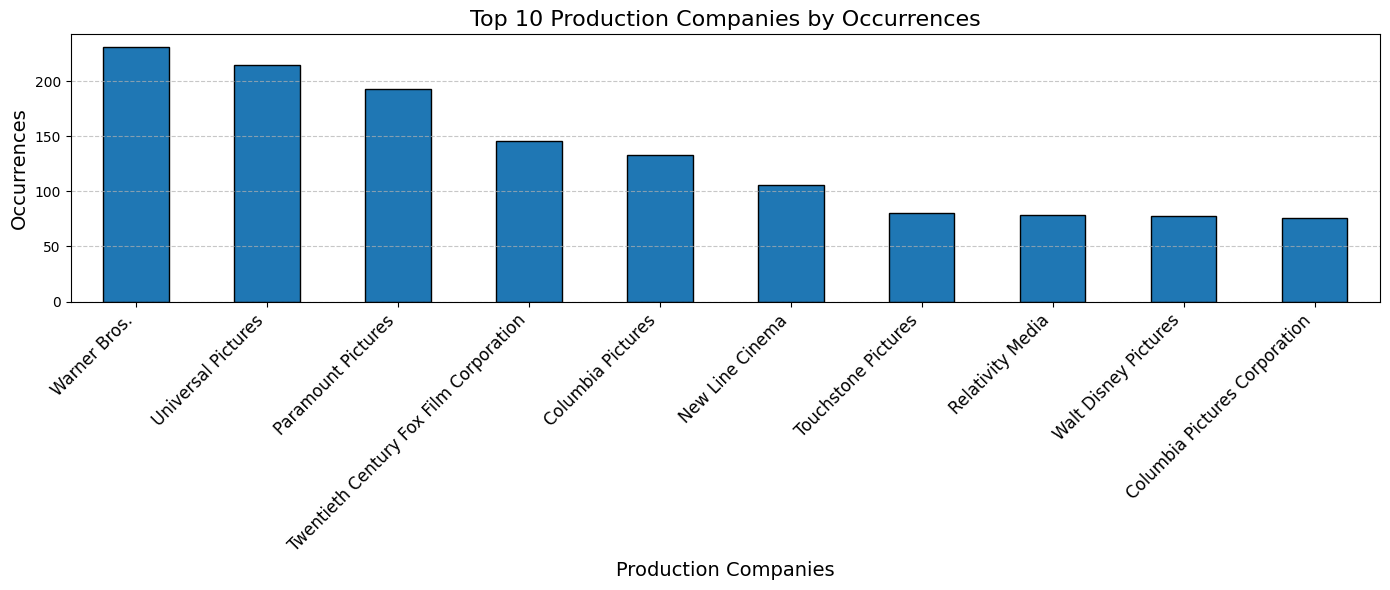

In [74]:
filtered_production_count = eda.analyze_production_companies()

In [75]:
prod_companies = pd.read_csv("data/Extra CSV/production_companies.csv")

box_office = eda.merge_production_data(filtered_production_count, prod_companies)


We inspect the company names and we saw that there are Columbia Pictures and Columbia Pictures Corporation. There are two names for the same company. 
We apply unify_columbia_revenue to attribute the same revenue for them. 

In [76]:
eda.unify_columbia_revenue(box_office_df=box_office)


In [77]:
box_office["Total Worldwide Box Office"] = box_office["Total Worldwide Box Office"].replace(
    {"\$": "", ",": ""}, regex=True).astype(float)

def calculate_box_office(companies_list):
   if not companies_list:
        return 0  
   return box_office.loc[box_office["Company Name"].isin(companies_list), "Total Worldwide Box Office"].sum()

eda.dataframe["Box_office_companies"] = eda.dataframe["Production_companies_cleaned"].apply(calculate_box_office)
eda.filter_movies_with_box_office(box_office_column="Box_office_companies")

After removing rows without Box Office revenue, 2221 movies remain out of 2221.


In [78]:
eda.plot_gender_comparison(columns=["log_ROI", "Normalized_Rating"])

In [79]:
eda.plot_gender_comparison(columns=["log_ROI", "Normalized_Rating"], interactive=True)

## je regle ca asap juste la ca me pete les couilles 

In [80]:
print(eda.dataframe.columns)


Index(['tconst', 'Average_ratings', 'Num_votes', 'Primary_title',
       'Original_title', 'Is_adult', 'Start_year', 'Directors', 'Writers',
       'Movie_release_date', 'Movie_languages', 'Movie_countries',
       'Movie_genres', 'Cast', 'Female_actors', 'Male_actors',
       'Female_actor_percentage', 'Movie_runtime', 'Plot Summaries',
       'Popularity', 'Production_companies', 'production_countries',
       'Movie_budget', 'Final_movie_revenue', 'ROI', 'Normalized_Rating',
       'log_ROI', 'log_Num_votes', 'Movie_main_genre', 'Main_genre_comedy',
       'Main_genre_drama', 'Main_genre_fantasy', 'Main_genre_horror',
       'Main_genre_thriller', 'Is_not_only_english', 'Is_USA_movie',
       'Production_companies_cleaned', 'Box_office_companies'],
      dtype='object')


### 1.2 Identifying Potential Confounders
In order to not have bias in our study, it is essential we add the confounders. This means that we have to identify the variables that have an impact on both treatment and outcome, here being the actor gender and the final box office revenue respectivly. The confounders are: 
-  ⁠Movie_genre
-  ⁠Movie_countries
- ⁠Movie_languages
- Num_votes

### 1.3 General Linear Regression

In [81]:
final_df_regression = eda.dataframe.copy()

# Calculating the Movie Success metric
final_df_regression = evaluation_utils.calculate_weighted_success(final_df_regression, 0.67)

We will run a different regression for each of the following dependent variables:
- $ln(\text{ROI})$
- Normalized Ratings
- Movie Success metric

Let's start with $ln(\text{ROI})$:

In [82]:
# Define independent and dependent variables
indep_vars = ["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie",  "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_fantasy", "Main_genre_horror", "Movie_release_date",
                   "Box_office_companies", "log_Num_votes"]

dep_var = "log_ROI"

# Run the regression along with necessary preprocessing and metrics
regression.run_regression(final_df_regression, indep_vars, dep_var)

------------------------------------------------------------------------------------------------
All VIF values are below 5. Multicollinearity is not a concern.
------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                log_ROI   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     72.82
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          5.25e-154
Time:                        04:02:32   Log-Likelihood:                -2505.3
No. Observations:                1776   AIC:                             5039.
Df Residuals:                    1762   BIC:                             5115.
Df Model:                          13                                         
Covariance Type:            non

Let us analyze the results from the regression on `log_ROI`:
- **$F$-statistic**: The p-value of the F-statistic is almost equal to zero. This means we can reject the null hypothesis that all coefficients are equal to zero at the 5% significance level, leading us to conclude that the model is statistically significant at the 5% significance level.

- **$R^2$ and Adjusted $R^2$**: The $R^2$ value indicates a moderate fit, however a significant portion of the variance (around 65%) is not explained, suggesting factors not included in the model might influence `log_ROI`. The Adjusted $R^2$ being close to the $R^2$ suggests the model is not overfitting.

- **Durbin-Watson statistic**: The Durbin-Watson statistic is close to 2 suggesting there is no autocorrelation of the residuals in the model.

- **RMSE**: The Root mean squared error is of 0.96, indicating a relative error of 7.46% on the test set.

- **Insignificant predictors**: `Is_not_only_english`, `Main_genre_thriller`, `Main_genre_fantasy` and `Production_companies` are all statistically insignificant at the 5% significance level.

- **Notable coefficients**: It can be noted amongst the statistically significant predictors that the number of female actors has a positive coefficient as opposed to the number of male actors having a negative one. This suggests that movies with more women perform better in terms of return on investment. Is this increase in performance due to the right reasons? We will dive deeper into that in Part 5 of our analysis.

Let's now regress on the Normalized Ratings and the Movie Success metric:

In [83]:
# Removing log_Num_votes as it is involved in the calculation of Normalized_Rating and Movie_success
indep_vars.remove("log_Num_votes")

# Define new dependent variables
dep_vars = ["Normalized_Rating", "Movie_success"]

show_VIF = True
for dep_var in dep_vars:
    # Run the regression along with necessary preprocessing and metrics
    regression.run_regression(final_df_regression, indep_vars, dep_var, show_VIF)
    
    # Only display VIF information once as the independent variables have not changed
    show_VIF = False

------------------------------------------------------------------------------------------------
All VIF values are below 5. Multicollinearity is not a concern.
------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:      Normalized_Rating   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     48.58
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          1.85e-100
Time:                        04:02:33   Log-Likelihood:                 1795.0
No. Observations:                1776   AIC:                            -3564.
Df Residuals:                    1763   BIC:                            -3493.
Df Model:                          12                                         
Covariance Type:            non

Let us analyze the regression on `Normalized_Rating` first:
- **$F$-statistic**: The p-value of the F-statistic is nearly zero. This allows us to reject the null hypothesis that all coefficients are equal to zero at the 5% significance level we can conclude that the model is statistically significant.

- **$R^2$ and Adjusted $R^2$**: The \( R^2 \) value indicates that approximately 24.9% of the variance in `Normalized_Rating` is explained by the predictors. The adjusted \( R^2 \) being close to \( R^2 \) suggests that the model is not overfitting.

- **Durbin-Watson statistic**: The Durbin-Watson statistic is close to 2, indicating no significant autocorrelation in the residuals.

- **RMSE**: The Root Mean Squared Error is 0.08, with a relative error of 11.25% on the test set. This suggests the model does not make big errors on the test dataset

- **Insignificant predictors**: `Is_USA_movie` and `Main_genre_horror` are statistically insignificant at the 5% significance level.

- **Notable coefficients**:
  - The number of female actors has a negative coefficient and is statistically significant, suggesting that an increase in female actors slightly decreases the normalized rating whilst the number of male actors has a positive coefficient and is significant, suggesting an increase in male actors is associated with a higher normalized rating. These results are opposite to what was seen with `log_ROI`


Let us analyze the regression on `Movie_Success` next:
- **$F$-statistic**: The p-value of the F-statistic is nearly zero. This allows us to reject the null hypothesis that all coefficients are equal to zero at the 5% significance level, we can conclude that the model is statistically significant.

- **$R^2$ and Adjusted $R^2$**: The \( R^2 \)suggests that only 10.2% of the variance is explained by the predictors. The low \( R^2 \) indicates that a significant portion of the variance remains unexplained, suggesting that additional factors may contribute to `Movie_Success`. The adjusted \( R^2 \) being close to \( R^2 \) suggests no overfitting.

- **Durbin-Watson statistic**: The Durbin-Watson statistic is close to 2, indicating no significant autocorrelation in the residuals.

- **RMSE**: The RMSE is 0.11, with a relative error of 10.64% on the test set. This suggests a reasonable level of accuracy in predicting `Movie_Success`.

- **Insignificant predictors**: `Female_actors`, `Is_USA_movie`, `Main_genre_thriller`, and `Box_office_companies` are statistically insignificant at the 5% significance level.

An important factor to note is that genres' significance varies from one regression to the next. Indeed, the expectations gender wise of movies varies largely from one genre to the next. It is thus important to take a deeper look into the different genres. We will analyze these differences thanks to genre specific linear regressions.

### 1.4 Genre specific Linear Regression

In this section, we will run regressions of subsets of our dataset corresponding to each main genre we have identified. This will produce many different regressions. The same rigourous analysis was conducted on each regression results. However, to avoid cluttering the notebook, we will not go into as much detail and only report notable results.

In [84]:
# Setting up the genre columns
genre_columns = ["Main_genre_drama", "Main_genre_thriller", "Main_genre_comedy", 
                "Main_genre_fantasy", "Main_genre_horror"]

# Define variables for regression on individual genres
indep_vars = ["Female_actors", "Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Movie_release_date","Box_office_companies", "log_Num_votes"]

# Setting up the dependent variable
dep_var = "log_ROI"

show_VIF = True
for genre in genre_columns:
    # Run the genre specific regression along with necessary preprocessing and metrics
    regression.run_regression(final_df_regression, indep_vars, dep_var, show_VIF, genre)
    
    # Only display VIF information once as the independent variables have not changed
    show_VIF = False

Running regression for genre: Drama
------------------------------------------------------------------------------------------------
All VIF values are below 5. Multicollinearity is not a concern.
------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                log_ROI   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     25.93
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           5.26e-33
Time:                        04:02:33   Log-Likelihood:                -686.65
No. Observations:                 462   AIC:                             1391.
Df Residuals:                     453   BIC:                             1429.
Df Model:                           8                                     

- **Drama**: 
  - **Male_actors**: Negative coefficient and not significant at the 5% level, \(p = 0.079\). Suggests that having more male actors is associated with a slight decrease in `log_ROI`, though this is not strongly significant.
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.375\). Gender composition of the cast does not appear to significantly influence ROI for drama films.
  - **Movie_runtime**: Significant negative impact, \(p < 0.001\), indicating longer dramas are associated with lower ROI.

- **Thriller**: 
  - **Female_actors**: Positive and significant coefficient, \(p = 0.010\). An increase in female actors is associated with a higher ROI for thrillers, suggesting that female representation may positively impact returns in this genre.
  - **Male_actors**: not significant at the 5% level, \(p = 0.541\). Male actor representation has no noticeable impact on ROI for thrillers.
  - **Movie_runtime**: Significant negative impact, \(p < 0.001\). Longer thrillers tend to have lower ROI.

- **Comedy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.320\). Female representation does not significantly influence ROI in comedies.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.313\). Male representation also has no significant impact on ROI for comedies.
  - **Movie_release_date**: Significant negative impact, \(p < 0.001\). Older comedy movies tend to have higher ROI.

- **Fantasy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.055\). Having more female actors does not significantly increase ROI for fantasy movies.
  - **Male_actors**: not significant at the 5% level, \(p = 0.547\). Male representation has no noticeable impact on ROI for fantasy movies.
  - **Movie_runtime**: Significant negative impact, \(p = 0.016\). Longer fantasy movies are associated with lower ROI.

- **Horror**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.574\). Female representation has no significant impact on ROI for horror movies.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.227\). Male representation shows no significant impact on ROI.
  - **log_Num_votes**: Positive and significant coefficient, \(p = 0.046\). Popularity (as measured by votes) is a stronger driver of ROI for horror movies than gender representation.
  - **Model Significance**: Overall \(R^2 = 0.172\) and an insignificant F-statistic, \(p = 0.158\), suggest that this model does not explain much of the variance in ROI for horror movies.

- **General Observations**: 
  1. The impact of **female actors** is most pronounced in the **thriller genre**, where it significantly increases ROI, \(p = 0.010\).
  2. **Male actors** consistently show negative or insignificant effects on ROI across all genres.
  3. The **runtime** of movies has a strong negative impact on ROI across most genres (e.g., Drama, Thriller, Fantasy).
  4. The **Fantasy genre** shows that female actors do not significantly influence ROI, \(p = 0.055\).
  5. The **Horror genre** model appears poorly fitted overall, with insignificant predictors and low explanatory power. Gender effects are negligible here.

In [85]:
# Removing log_Num_votes as it is involved in the calculation of Movie_success
indep_vars.remove("log_Num_votes")

# Setting up the dependent variable
dep_var = "Movie_success"

show_VIF = True
for genre in genre_columns:
    # Run the genre specific regression along with necessary preprocessing and metrics
    regression.run_regression(final_df_regression, indep_vars, dep_var, show_VIF, genre)
    
    # Only display VIF information once as the independent variables have not changed
    show_VIF = False

Running regression for genre: Drama
------------------------------------------------------------------------------------------------
All VIF values are below 5. Multicollinearity is not a concern.
------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:          Movie_success   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.488
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           2.64e-07
Time:                        04:02:33   Log-Likelihood:                 355.35
No. Observations:                 462   AIC:                            -694.7
Df Residuals:                     454   BIC:                            -661.6
Df Model:                           7                                     

- **Drama**: 
  - **Female_actors**: Negative but not significant at the 5% level, \(p = 0.342\). Female representation does not significantly influence movie success in drama films.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.731\). Male representation also shows no significant impact on movie success.
  - **Movie_runtime**: Positive and significant, \(p = 0.034\). Longer runtime is associated with higher success for drama films.
  - **Is_not_only_english**: Positive and significant, \(p = 0.002\). Non-English drama movies tend to have higher success.
  - **Movie_release_date**: Negative and significant, \(p < 0.001\). Older drama movies tend to have higher success.

- **Thriller**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.064\). Female representation does not significantly influence movie success in thrillers.
  - **Male_actors**: not significant at the 5% level, \(p = 0.764\). Male representation has no noticeable impact on movie success for thrillers.
  - **Movie_runtime**: Positive and significant, \(p < 0.001\). Longer runtime is associated with higher success for thrillers.
  - **Movie_release_date**: Negative and significant, \(p < 0.001\). Older thriller movies tend to have higher success.

- **Comedy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.445\). Female representation does not significantly influence movie success in comedies.
  - **Male_actors**: Positive and significant, \(p = 0.011\). An increase in male actors is associated with higher success in comedy films.
  - **Movie_runtime**: Positive and significant, \(p = 0.001\). Longer runtime is associated with higher success for comedies.
  - **Is_not_only_english**: Positive and significant, \(p = 0.014\). Non-English comedy movies tend to have higher success.
  - **Movie_release_date**: Negative and significant, \(p = 0.006\). Older comedy movies tend to have higher success.

- **Fantasy**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.813\). Female representation does not significantly influence movie success in fantasy films.
  - **Male_actors**: Positive and significant, \(p = 0.020\). An increase in male actors is associated with higher success in fantasy movies.
  - **Movie_runtime**: not significant at the 5% level, \(p = 0.476\). Runtime has no noticeable impact on success for fantasy movies.
  - **Box_office_companies**: Negative but not significant at the 5% level, \(p = 0.072\). A higher number of box office companies may slightly reduce success, but the result is not strongly significant.

- **Horror**: 
  - **Female_actors**: Positive but not significant at the 5% level, \(p = 0.796\). Female representation has no significant impact on movie success in horror films.
  - **Male_actors**: Negative but not significant at the 5% level, \(p = 0.625\). Male representation shows no significant impact on movie success.
  - **Movie_runtime**: Negative but not significant at the 5% level, \(p = 0.190\). Runtime does not significantly influence success for horror films.
  - **Model Significance**: Overall \(R^2 = 0.062\) and an insignificant F-statistic, \(p = 0.772\), suggest that this model does not explain much of the variance in movie success for horror films.

- **General Observations**: 
  1. The impact of **female actors** is not significant at the 5% level across all genres.
  2. **Male actors** have a significant positive impact on success in **comedy** and **fantasy** genres, but no noticeable impact in other genres.
  3. **Movie_runtime** positively influences movie success in **drama**, **thriller**, and **comedy** genres, while having no significant impact in **fantasy** and **horror**.
  4. **Movie_release_date** is consistently negative and significant for **drama**, **thriller**, and **comedy**, suggesting older movies perform better in these genres.
  5. The **horror genre** model has low explanatory power, with no significant predictors and a high relative error.

### 4. How does it compare to streaming platforms?

In this section, we want to expand our study by analyzing data from various streaming platforms. We focus on the movies of Netflix, Amazon Prime, Disney+, and Hulu. To achieve this, we created a dataset by merging data from multiple sources found on Kaggle.


This dataset structure enables comprehensive analysis across various dimensions such as gender repartition in the cast, the ratings and description. Using these columns, we can investigate how streaming platform movies differ in content and ratings compared to traditional box office movies.



In [86]:
streaming_df = get_streaming_dataframe()

In [87]:
streaming_df.head()

,Show_id,Type,Movie_name,Director,Cast,Movie_countries,Date_added,Movie_release_date,Age_ratings,Movie_runtime,Movie_genres,Description,Platform,Male_actors,Female_actors,Average_ratings,Num_votes,Is_Adult,Movie_languages
1,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125.00,Drama & Emotion,"On a photo shoot in Ghana, an American model s...",Netflix,2,2,7.00,859,1,"German, French, English"
2,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104.00,"Comedy & Light-Hearted, Drama & Emotion",A woman adjusting to life after a loss contend...,Netflix,5,6,6.40,15653,0,English
3,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127.00,Drama & Emotion,After most of her family is murdered in a terr...,Netflix,3,6,5.60,1622,1,"Czech, German"
8,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166.00,"Comedy & Light-Hearted, Drama & Emotion",When the father of the man she loves insists t...,Netflix,0,1,6.50,4085,0,Hindi
9,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,"September 20, 2021",2010,PG-13,103.00,Comedy & Light-Hearted,Mourning the loss of their beloved junior high...,Netflix,5,6,6.00,286335,0,English


In [88]:
streaming_df.drop_duplicates(inplace=True)


a. <u>Numerical Analysis</u>: 

In [89]:
eda_streaming = EDA(streaming_df.copy())


In [90]:
pd.options.display.float_format = "{:,.2f}".format

# Filtrer uniquement les colonnes qui existent dans la dataframe
existing_numeric_columns = [col for col in eda_streaming.numeric_columns if col in eda_streaming.dataframe.columns]

# Convert columns to numeric for existing columns and drop rows with missing data
eda_streaming.dataframe[existing_numeric_columns] = eda_streaming.dataframe[existing_numeric_columns].apply(pd.to_numeric, errors="coerce")
eda_streaming.dataframe.dropna(subset=existing_numeric_columns, inplace=True)

# Summary statistics
summary_table = eda_streaming.summary_bis()

summary_table


,Min,Max,Mean,SD,Median
Average_ratings,1.50,10.00,6.31,1.20,6.40
Num_votes,5.00,"2,612,159.00","42,414.68","135,616.58","2,596.00"
Movie_release_date,"1,928.00","2,021.00","2,011.11",12.13,"2,016.00"
Movie_runtime,4.00,312.00,103.19,27.68,101.00
Female_actors,0.00,27.00,3.23,2.23,3.00
Male_actors,0.00,35.00,4.06,2.59,4.00


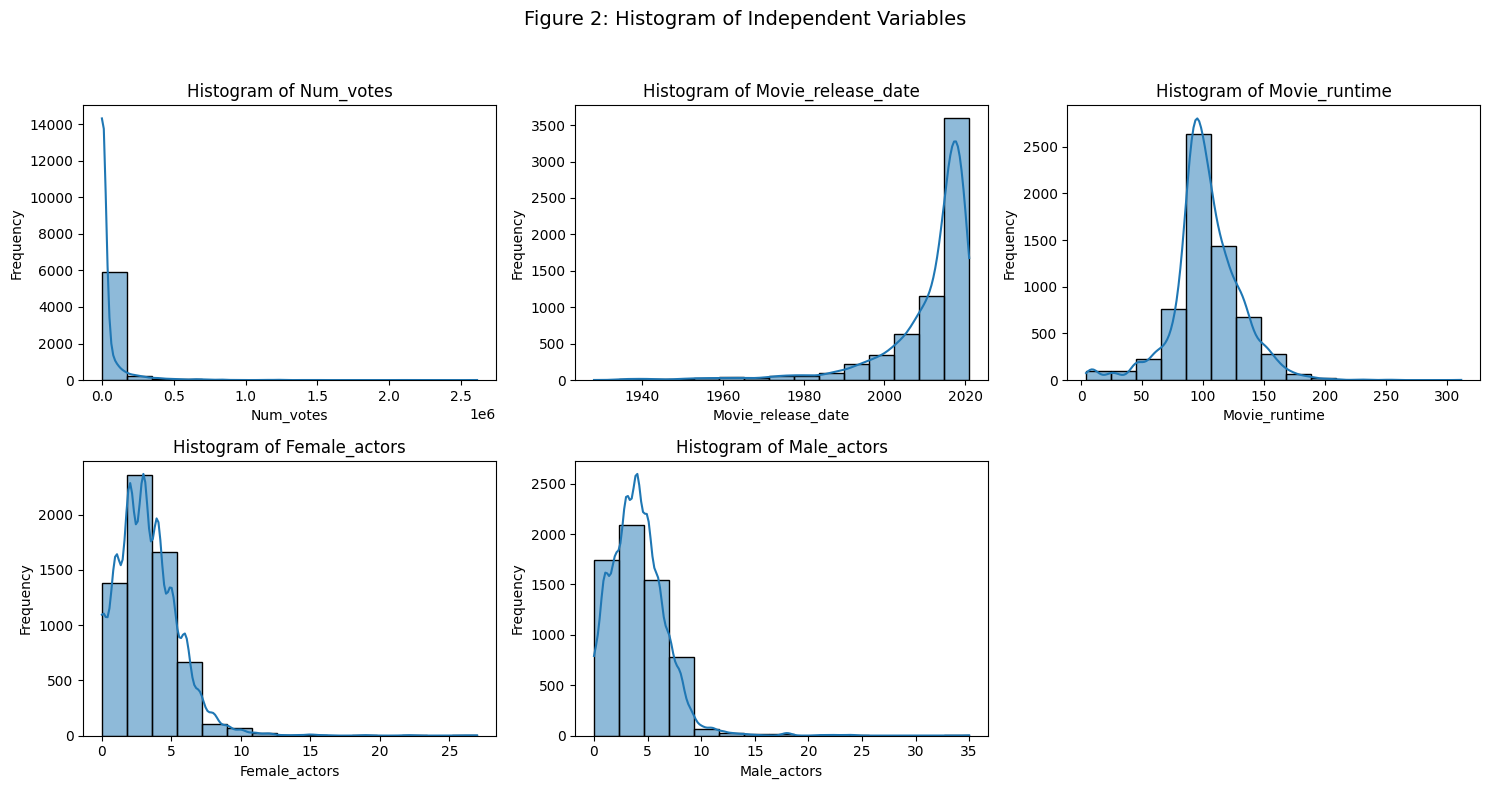

In [91]:
eda_streaming.plot_histograms(
    variables=["Num_votes", "Movie_release_date", "Movie_runtime", "Female_actors", "Male_actors"],
    title="Figure 2: Histogram of Independent Variables",
    bins=15,
    layout=(2, 3)
)

Release_year : The majority of movies in the dataset are very recent with an increase after the year 2000. This distribution seems to be logical beause streaming platform really took place recently.

Movie_runtime: The duration of most movies is between 90 and 120 minutes, which is typical for films.

Female_count and male_count: We can see that the number of men is greater than women but this difference is lower than for CMU/IMDB movies.



## PEUT ETRE CHANGER LE SCALE DE NUMVOTES

In [92]:
# Apply log transformation to skewed independent variables
eda_streaming.dataframe = evaluation_utils.log_transform(eda_streaming.dataframe, ["Num_votes", "Movie_runtime", "Female_actors", "Male_actors"])

eda_streaming.plot_log_transformed_independent_histograms()

AttributeError: 'EDA' object has no attribute 'plot_log_transformed_independent_histograms'

Log_Num_Votes : The histogram shows a near symmetric distribution of log transformed movie votes resembling a normal distribution. Most movies have log-votes between 6 and 10.

Log_Movie_runtime: Most movies have a log runtime between 4 and 5, with the distribution slightly skewed to the right.

Log_Male_actors and log_female_actors : The log of female actors is slightly lower than the log of male actors. 

In [ ]:
eda_streaming.numeric_columns = ["Average_ratings",
                   "log_Num_votes",
                   "Movie_release_date",
                   #"log_Final_movie_revenue",
                   #"log_ROI",   # je crois juste lui je le teje 
                   "log_Movie_runtime",
                   "log_Female_actors",
                   "log_Male_actors",
                   #"Movie_success"
                   ]

eda_streaming.plot_boxplots()

As we did in the previous part, we now have to focus on outliers and removing them for a more accurate modeling.

In [ ]:

eda_streaming.dataframe = data_utils.remove_outliers(eda_streaming.dataframe, eda_streaming.numeric_columns)

eda_streaming.plot_boxplots()

In [ ]:
print(f"After removing the outliers and dropping the null values, we are left with {len(eda_streaming.dataframe):,} movies.")

##### 4.1.2 Bivariate Analysis of continuous variables

In [ ]:
eda_streaming.plot_correlation_matrix()

The number of votes and gender composition (especially the number of male actors) seem to influence movie duration. It suggests that popularity and cast composition could impact movie production characteristics.
Weak correlations between movie duration and other variables indicate that duration might not strongly determine popularity based on votes.
This correlation matrix suggests further analysis like regression that could help separate and clarify the effects of gender and duration on popularity.

#### 4.1.3 Analysis and encoding of categorical variables
Regression analysis with many categorical variables can quickly get complicated. Indeed using a boolean value for each category except one can cause us to have too many regressors. For variables like isAdult and Gender it is easy as there are only two possibilities. However, for Movie_genre, Movie_countries and Movie_languages we can quickly get into the hundreds. Here is how we plan on managing this:

##### 4.1.3.1 Analysis of the Movies' genres

We set a cutoff threshold of 500. This means all genres with less than 500 occurences will be discarded. 

In [ ]:
filtered_genre_counts = eda_streaming.filter_and_count(column_name="Movie_genres", threshold=500)

Let us check if this restricts our study to too few movies.

In [ ]:
popular_genres = eda_streaming.analyze_popular_genres(filtered_genre_counts=filtered_genre_counts)

We choose to only keep only the movies xhich have at more 2 genres and create dummies with all other combinations.

In [ ]:
eda_streaming.dataframe = eda_streaming.dataframe[eda_streaming.dataframe["Movie_genres"].apply(lambda x: len(x.split(",")) <= 2)]

In [ ]:
eda_streaming.dataframe["Movie_genres"].value_counts()

In [ ]:

dummies = pd.get_dummies(eda_streaming.dataframe["Movie_genres"], prefix="Movie_genres", drop_first=True)

dummy_columns = dummies.columns.tolist()
print("Dummies columns :", dummy_columns)


In [ ]:
#eda_streaming.dataframe = pd.get_dummies(eda_streaming.dataframe, columns=["Movie_genres"], drop_first=True) 
eda_streaming.dataframe = pd.concat([eda_streaming.dataframe, dummies], axis=1)

eda_streaming.dataframe.sample(5)

##### 1.1.3.2 Analysis of the Movies' languages

We will plot the top 5 languages by number of occurences:

In [ ]:
eda_streaming.analyze_languages()

Categorizing movies into two groups: 
- those available exclusively in English, 
- those available in other languages (which may include English alongside another language).

This will be done through the creation of the boolean "Is_not_only_english" which is True when the movie is available in another language.

In [ ]:
eda_streaming.categorize_languages()

##### 1.1.3.2 Analysis of the Movies' countries

In [ ]:
eda_streaming.analyze_countries()

We have a very similar situation to the languages. The United States of America have a much more prominent number of movies. We will thus proceed like previously by categorizing the movies into two groups:
- USA movies 
- Movies from other countries 

This will be done through the creation of the boolean "Is_USA_movie" which is True when the movie is from the USA.

In [ ]:
count_usa_movies = (eda_streaming.dataframe["Movie_countries"] == "United States").sum()
count_other_countries_movie = len(eda_streaming.dataframe) - count_usa_movies 
print(f"There are {count_usa_movies} USA movies and {count_other_countries_movie} movies from other countries.")

In [ ]:
eda_streaming.categorize_countries_bis()

##### 1.1.3.2 Analysis of the Movies' streaming platforms 

We created dummy variables for the streaming platforms(Netflix, Disney, Amazon prime). Each platform is now a column with 0 or 1, where 1 means the movie is available on that platform.

In [ ]:
eda_streaming.dataframe = pd.get_dummies(eda_streaming.dataframe, columns=["Platform"], drop_first=True) 
eda_streaming.dataframe.sample(5)

### 1.3 Linear Regression

In [ ]:
streaming_df_regression = eda_streaming.dataframe.copy()

In [ ]:
print(streaming_df_regression.columns)

In [ ]:
indep_vars1=["log_Female_actors", "log_Male_actors", "Num_votes", "log_Movie_runtime", "Is_not_only_english", "Is_USA_movie",
          'Platform_Disney', 'Platform_Netflix', "Is_Adult"]

indep_vars=np.hstack([indep_vars1, dummy_columns])
dep_vars = "Average_ratings"

X = streaming_df_regression[indep_vars]
y = streaming_df_regression[dep_vars]

scaler = StandardScaler()
X_scaled_streaming = scaler.fit_transform(X)

X_scaled_streaming = pd.DataFrame(X_scaled_streaming, columns=X.columns, index=X.index)

X_scaled_wconst_streaming = sm.add_constant(X_scaled_streaming)

In [ ]:
# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled_streaming.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled_streaming.values, i) for i in range(X_scaled_streaming.shape[1])]

# Display VIF values
print(vif_data)

In [ ]:
model_streaming = sm.OLS(y, X_scaled_wconst_streaming).fit()
print(model_streaming.summary())

### 5. <u>What are the social reasons behind the presence of female characters in movies? Is it due to sexualization or genuine equality of representation?</u>

The first part of our analysis uses plot summaries to examine whether female characters are portrayed as having agency (taking action and driving the story) or are reduced to sexualized or objectified roles. So far, we have used LLMs, such as ChatGPT Plus, to classify plot summaries based on these criteria (contains/does not contain sexualization of females), which provided useful initial results and validated the approach. However, due to time constraints during milestone 2, we were unable to use more advanced methods, such as zero-shot or few-shot learning with models like OpenAI's GPT-4, T5, or BERT variants, which we plan to explore further in milestone 3.
The second part of our analysis focuses on adult-rated films in the resulting merged dataframe, specifically examining the gender of the actors to understand patterns of representation.

In [ ]:
bechdel_df = pd.read_csv("data/Bechdel test/bechdel_test_movies.csv", names=["Id", "Year", "Title", "Bechdel_rating", "tconst"], header=None)

bechdel_df = bechdel_df.drop(index=0)
bechdel_df.head()

In [ ]:
bechdel_df["tconst"] = bechdel_df["tconst"].apply(lambda x : "tt"+str(x))
bechdel_df.head()

In [ ]:
final_final_df = pd.merge(eda.dataframe.copy(), bechdel_df, on="tconst")
len(final_final_df)

In [ ]:
final_final_df.drop(columns=["tconst"])
final_final_df["Bechdel_rating"].value_counts()

In [ ]:
final_final_df["Bechdel_rating"] = pd.to_numeric(final_final_df["Bechdel_rating"])

In [ ]:
indep_cols = ["log_Female_actors", "log_Male_actors", "log_Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "Bechdel_rating", "log_Num_votes"]

X = final_final_df[indep_cols]

y = final_final_df["Log_ROI"]

In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

In [ ]:
indep_cols = ["log_Female_actors", "log_Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "Bechdel_rating", "Log_ROI"]

X = final_final_df[indep_cols]

y = final_final_df["Normalized_Rating"]

In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

In [ ]:
indep_cols = ["log_Female_actors", "log_Male_actors", "Movie_runtime", "Is_not_only_english", 
                   "Is_USA_movie", "Main_genre_drama",
                   "Main_genre_thriller", "Main_genre_comedy", "Main_genre_romance_film", "Start_year",
                   "Box_office_companies", "Log_ROI"]

X = final_final_df[indep_cols]

y = final_final_df["Bechdel_rating"]

In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_scaled_wconst = sm.add_constant(X_scaled)

model = sm.OLS(y, X_scaled_wconst).fit()
print(model.summary())

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# Display VIF values
print(vif_data)

## New Dialogue dataset

In [ ]:
movie_dialogue_df = pd.read_csv("data/Dialogue/meta_data7.csv",
                                names=["Script_id", "tconst", "Title", "Year", "Gross", "Lines_Data"], 
                                header=0, 
                                encoding="ISO-8859-1")
movie_dialogue_df.drop(columns=["Gross", "Lines_Data"], inplace=True)
movie_dialogue_df.head()

In [ ]:
character_dialogue_df = pd.read_csv("data/Dialogue/character_list5.csv",
                                    names=["Script_id", "Character_name", "Words", "Gender", "Age"], 
                                    header=0, 
                                    encoding="ISO-8859-1", 
                                    na_values= "?")
character_dialogue_df.dropna(subset=["Character_name", "Age"], inplace=True)
character_dialogue_df.head()

In [ ]:
dialogue_df = pd.merge(movie_dialogue_df, character_dialogue_df, on="Script_id")
dialogue_df.drop(columns=["Script_id"], inplace = True)

dialogue_gender_words_df = dialogue_df.drop(columns=["Character_name", "Age", "Year", "Title"])
dialogue_gender_words_df.head()

In [ ]:
# Group by movie and gender 
gender_word_count_df = dialogue_gender_words_df.groupby(["tconst", "Gender"])["Words"].sum().unstack()
gender_word_count_df = gender_word_count_df.rename(columns={"f": "Female_word_count", "m": "Male_word_count"})

# Calculate total words per movie
gender_word_count_df["Total_word_count"] = gender_word_count_df.sum(axis=1)

gender_word_count_df = gender_word_count_df.reset_index()
gender_word_count_df.columns.name = None 

# Calculate the percentage of words for each gender
gender_word_count_df['Word_percentage_men'] = (gender_word_count_df['Male_word_count'] / gender_word_count_df['Total_word_count']) * 100
gender_word_count_df['Word_percentage_women'] = (gender_word_count_df['Female_word_count'] / gender_word_count_df['Total_word_count']) * 100

gender_word_count_df.head()

In [ ]:
# Prepare data for plotting
percentage_df = pd.DataFrame({
    "Percentage": list(gender_word_count_df['Word_percentage_men']) + list(gender_word_count_df['Word_percentage_women']),
    "Gender": ["Men"] * len(gender_word_count_df) + ["Women"] * len(gender_word_count_df)
})
# Create the histogram
fig = px.histogram(
    percentage_df, 
    x="Percentage", 
    color="Gender",
    nbins=50,
    opacity=0.6,
    title="Distribution of Word Percentage Spoken by Men and Women in Movies",
    labels={"Percentage": "Percentage of Words Spoken", "Gender": "Gender"}
)
# Update layout for a clean look
fig.update_layout(
    yaxis_title="Number of Movies",  
    barmode='overlay'  # Overlay bars for transparency
)
fig.show()

In [ ]:
final_dialogue_df = dialogue_df.groupby("tconst").agg(
    Characters=("Character_name", list),
    Words=("Words", list),
    Gender=("Gender", list)
)
final_dialogue_df.head()

In [ ]:
dialogue_merged_df = pd.merge(final_df, final_dialogue_df, on="tconst")
len(dialogue_merged_df)